### Fig. 8

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import sys, os
# sys.path.append('../src/')
sys.path.append('/home/caoyuyao/dataset_14T/UID-Moji/src') # --qg
from sklearn.neighbors import KDTree, BallTree
from visualization import ObservationMap
from utils import get_hour_list, load_weather_data, TcTools, get_elevation_grid, truncate_colormap
from quality_control import QualityControlTool
from tqdm import tqdm
from datetime import datetime, timedelta
from functools import lru_cache
import pandas as pd
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
from matplotlib import font_manager 
font_path = "/mnt/cyy14/data_qg/old_draw/font"
font_files = font_manager.findSystemFonts(fontpaths=font_path)
for file in font_files:
    font_manager.fontManager.addfont(file)
plt.rcParams["font.sans-serif"] = "Arial"


lon_range = [117.2, 123.2]
lat_range = [27.3, 33.3]
grid_resol = 0.01

lon_tick=list(range(118,124,1))
lat_tick=list(range(28,34,1))
jwwidth=0.2

lons = np.linspace(lon_range[0], lon_range[1], int((lon_range[1] - lon_range[0])*100) + 1)
lats = np.linspace(lat_range[0], lat_range[1], int((lat_range[1] - lat_range[0])*100) + 1)
lons = np.arange((lons[0] + lons[1])/2, lon_range[1], 0.01)
lats = np.arange((lats[0] + lats[1])/2, lat_range[1], 0.01)

lon_grid, lat_grid = np.meshgrid(lons, lats)
lon_array = lon_grid.flatten().reshape(-1, 1)
lat_array = lat_grid.flatten().reshape(-1, 1)
grid_loc_array = np.hstack((lon_array, lat_array))


test_stations = np.load('/mnt/cyy14/data_ANON_UID_compare/stations_for_test\
/2019030100-2019093023_117.2-123.2_27.3-33.3_test_stations.npy')


import netCDF4 as nc
from utils import get_hour_list, truncate_colormap, TcTools

def load_hourly_smartphone_data(hour_name):
    data_dir = '/mnt/cyy14/\
2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/' # --qg
    data = np.load(data_dir+hour_name+'_QCed_smartphone_data.npy')
    return data


    

def plot_station(hour_name, colorbar = False):
    station_data = get_QCed_station_data(hour_name)[:, np.array([1, 2, 4])]
    print(np.nanmin(station_data[:, 2]))
    
    obs_map = ObservationMap(llon = lon_range[0], rlon = lon_range[1], \
        llat = lat_range[0], ulat = lat_range[1])
    obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=999999,\
                    label_left=1, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True)
    
    num_colors = 10
    cmap = plt.get_cmap('Spectral_r', num_colors)
    
    cs_pre = obs_map.scatter(station_data[:, 0], station_data[:, 1], station_data[:, 2], \
        cmap = cmap, marker_size = 1, colorbar = colorbar, zorder=4)
    plt.clim(976, 996)
    
    tc_tool = TcTools()
    tc_lon, tc_lat = tc_tool.tc_center_dict[hour_name][0][:2]
    obs_map.scatter(lons = [tc_lon], lats = [tc_lat], marker = '+', marker_size = 200, color = 'red', \
        zorder = 99999)
    cs = obs_map.contourf(lon_grid, lat_grid, elevation_grid, levels = np.arange(300, 2100, 300), cmap = 'gist_yarg', \
        vmin = 300, vmax = 1800,zorder=1, latlon=True)
    
    return station_data.shape[0], cs_pre, obs_map
    
    
    
def plot_smartphone(hour_name, colorbar = False):
    smartphone_data = load_hourly_smartphone_data(hour_name)    
    obs_map = ObservationMap(llon = lon_range[0], rlon = lon_range[1], \
    llat = lat_range[0], ulat = lat_range[1])
    obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True, zorder=999999,\
                    label_left=0, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True)
    
    num_colors = 10
    cmap = plt.get_cmap('Spectral_r', num_colors)
    
    cs = obs_map.scatter(smartphone_data[:, 0], smartphone_data[:, 1], smartphone_data[:, 2], \
        cmap = cmap, marker_size = 1, colorbar = colorbar, zorder=4)
    plt.clim(976, 996)
    
    tc_tool = TcTools()
    tc_lon, tc_lat = tc_tool.tc_center_dict[hour_name][0][:2]
    obs_map.scatter(lons = [tc_lon], lats = [tc_lat], marker = '+', marker_size = 200, color = 'red', \
        zorder = 99999)
    cs = obs_map.contourf(lon_grid, lat_grid, elevation_grid, levels = np.arange(300, 2100, 300), cmap = 'gist_yarg', \
        vmin = 300, vmax = 1800,zorder=1, latlon=True)
    return smartphone_data.shape[0], cs, obs_map
    



def load_station_data(hour_name = '', minute = 0):
    '''
    hour_name: LST, should be transformed to UTC
    '''
    data_dir = '/home/caoyuyao/dataset/{:s}_AWS_pressure_60k_decoded/'.format(hour_name[:4])
    file_name = '{:s}_weather_station_data.npy'.format(hour_name)    
    return np.load(data_dir+file_name)



def get_QCed_station_data(hour_name):
    test_stations = [] 
    qc_tool = QualityControlTool()
    
    orig_station_data = load_station_data(hour_name)
    valid_ind = ~np.isnan(orig_station_data[:, 4])
    orig_station_data = orig_station_data[valid_ind, :]  
    

    station_data_dict = {}
    for i in range(len(orig_station_data)):
        station_id = str(int(orig_station_data[i, 0]))
        station_data_dict[station_id] = orig_station_data[i, 4]

    station_id_list = orig_station_data[:, 0].astype(np.int32).astype('U10')
    test_stations_ind = np.isin(station_id_list, test_stations)
    station_data = orig_station_data[~test_stations_ind, :]
    
    _, valid_ind = qc_tool.spatial_check_old(station_data[:, np.array([1, 2, 4])])
    station_data = station_data[valid_ind, :]
    

    station_lons = station_data[:, 1]
    station_lats = station_data[:, 2]
    region_ind = (station_lons>=lon_range[0] - 1) & (station_lons<=lon_range[1] + 1) & \
        (station_lats>=lat_range[0] - 1) & (station_lats<=lat_range[1] + 1)
    region_station_data = station_data[region_ind, :]

    return region_station_data



def draw_text(text):
    textx=0.02
    texty=0.98
    #textx=0.06
    #texty=0.96
    textpad='round,pad=0.2'
    
    plt.text(textx,texty, s = text, zorder=9999999, verticalalignment='top', horizontalalignment='left',\
fontsize=15, transform=ax.transAxes, bbox=dict(boxstyle=textpad, fc='white', ec='k',lw=1 ,alpha=0.7))
    
    return text

938.7999877929688


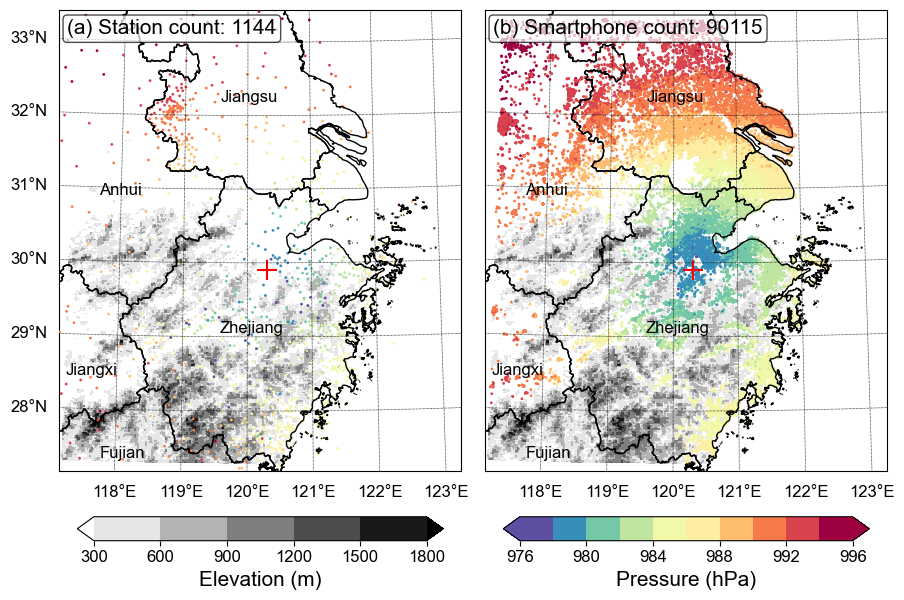

In [ ]:

fig=plt.figure(2)
fig.set_size_inches(12, 12)


mx=0.15
x0=0.345
y0=0.345/6.1*6.8

'''Add terrain'''
lon_range = [117.2, 123.2]
lat_range = [27.3, 33.3]
lon_list = np.arange(lon_range[0], lon_range[1]+0.01, 0.01)
lat_list = np.arange(lat_range[0], lat_range[1]+0.01, 0.01)
lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)
_, _, elevation_grid = get_elevation_grid(lon_range, lat_range, 0.01)

textx=0.04
texty=0.91
textpad='round,pad=0.2'

# (a)
hour_name = '2019081014'
#ax = axs[0, 0]
ax=plt.axes([mx, 0.5-y0/2, x0, y0])
plt.sca(ax)
station_count, cs_pre, obs_map= plot_station(hour_name)
draw_text('(a) Station count: {:d}'.format(station_count))

'''Add province name'''
tf=12
plt.text(0.4, 0.8, s = 'Jiangsu', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.4, 0.3, s = 'Zhejiang', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.6, s = 'Anhui', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.015, 0.21, s = 'Jiangxi', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.03, s = 'Fujian', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')



# (b)

ax=plt.axes([1-mx-x0, 0.5-y0/2, x0, y0])
plt.sca(ax)
sphn_count, cs, obs_map = plot_smartphone(hour_name)
draw_text('(b) Smartphone count: {:d}'.format(sphn_count))


'''Add province name'''
tf=12
plt.text(0.4, 0.8, s = 'Jiangsu', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.4, 0.3, s = 'Zhejiang', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.6, s = 'Anhui', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.015, 0.21, s = 'Jiangxi', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.03, s = 'Fujian', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')




cbar_ax = fig.add_axes([0.17, 0.25, 0.305, 0.02])
cl=fig.colorbar(cs, cax=cbar_ax, extend='both', orientation='horizontal')
cbar_ax.set_xlabel('Elevation (m)', fontsize = 15)
cl.ax.tick_params(labelsize=12)


cbar_ax = fig.add_axes([0.525, 0.25, 0.305, 0.02])
cl_pre=fig.colorbar(cs_pre, cax=cbar_ax, extend='both', orientation='horizontal')
cl_pre.set_ticks(list(range(976,997,4)))

cl_pre.ax.tick_params(labelsize=12)
cbar_ax.set_xlabel('Pressure (hPa)', fontsize = 15)


fig_dir = '/mnt/cyy14/data_qg/old_draw/submit/'
plt.savefig(fig_dir + 'f07.png', dpi = 300, format='png', bbox_inches = 'tight')

